# chickenpox-cases-lstm


Dataset: https://archive.ics.uci.edu/dataset/580/hungarian+chickenpox+cases

Este trabalho tem como objetivo implementar um modelo baseado em redes neurais recorrentes do tipo LSTM (Long Short-Term Memory) para a tarefa de previsão de séries temporais. O foco da análise é a previsão do número de casos nacionais de catapora na Hungria, a partir dos registros de casos em diferentes condados.

Além das aulas ministradas pelo Prof. Dr. Alexandre Rossini (UFT) e do material complementar disponibilizado virtualmente, foi utilizado como referência adicional o seguinte vídeo:
[Previsão de séries temporais com LSTM no TensorFlow/Keras](https://youtu.be/94PlBzgeq90?si=bxpaWFLu52zaRYcl)

In [ ]:
!pip install tensorflow scikit-learn pandas matplotlib


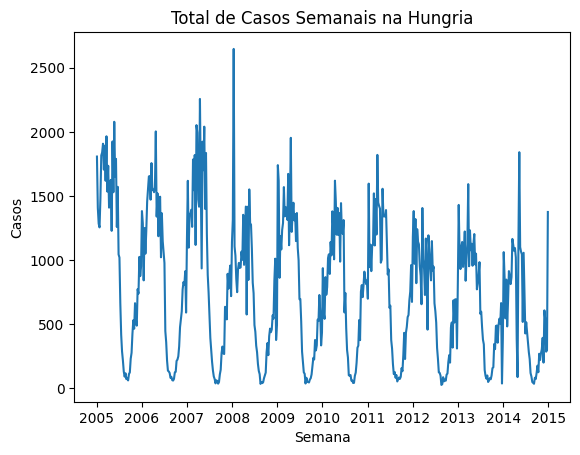

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar dataset
df = pd.read_csv('datasets/hungary_chickenpox.csv')
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df = df.sort_values('Date')  # garante a ordem temporal

# Criar coluna com o total nacional de casos por semana
df['Total'] = df.drop(columns='Date').sum(axis=1)

# Visualização opcional
plt.plot(df['Date'], df['Total'])
plt.title("Total de Casos Semanais na Hungria")
plt.xlabel("Semana")
plt.ylabel("Casos")
plt.savefig('deep-learning/chickenpox-cases-lstm/plots/total-casos-semanais-hungria.png')



In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Normalizar os dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Total']].values)

# Fix n_features to 1
n_features = 1

# Criar janelas com 'n_steps' semanas
n_steps = 40
X, y = create_sequences(scaled, n_steps)

# Reshape para [amostras, tempo, features]. Formato esperado pelo LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
split = int(len(X) * 0.70)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construir o modelo
model = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, 1), return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

from tensorflow.keras.losses import Huber

model.compile(optimizer='adam', loss=Huber(delta=0.5))
# model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0460 - val_loss: 0.0136
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0217 - val_loss: 0.0094
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0186 - val_loss: 0.0106
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0141 - val_loss: 0.0070
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0070 - val_loss: 0.0046
Epoch 12/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
MAE:  166.09
MSE:  56487.46
RMSE: 237.67
R²:   0.6712


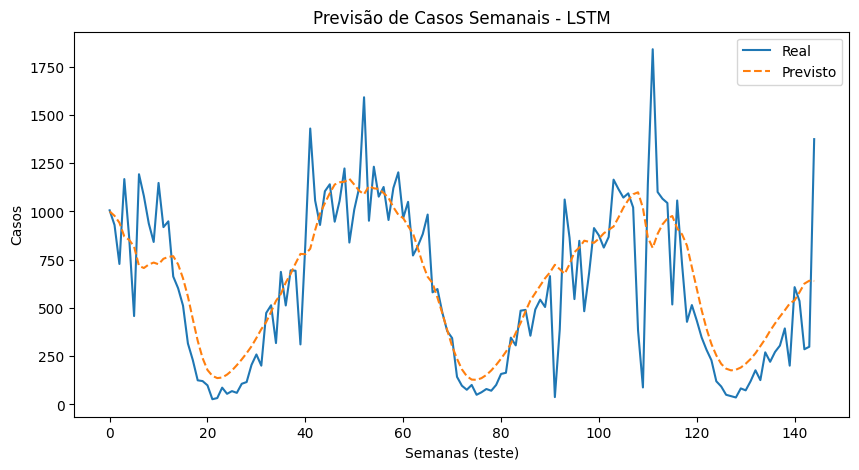

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Previsão
y_pred = model.predict(X_test)

# Inverter a normalização
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Métricas
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto', linestyle='dashed')
plt.title("Previsão de Casos Semanis - LSTM")
plt.xlabel("Semanas (teste)")
plt.ylabel("Casos")
plt.legend()
plt.savefig('deep-learning/chickenpox-cases-lstm/plots/previsao-casos-semanais')
